In [1]:
# !pip install pulp
# !pip install scanpy

In [1]:
from l1_coresets import uniform_sample_coreset, construct_strong_coreset_probabilities, construct_strong_coreset, construct_strong_coreset_probabilities_one_iteration, construct_strong_coreset_one_iteration
from l1_coresets import compute_median, evaluate_coreset

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pulp
from tqdm import tqdm
from scipy.spatial.distance import cityblock



def compare_coreset_methods(df, coreset_sizes=None, n_repeats=20):
    """
    Compare uniform and importance sampling coreset construction methods.

    Args:
        df: DataFrame containing float columns
        coreset_sizes: List of coreset sizes to test (default: 50 to 2000)
        n_repeats: Number of repeats for both methods to calculate standard deviation

    Returns:
        Dictionary of results for plotting
    """
    points = df.values
    # Default coreset sizes if not provided
    if coreset_sizes is None:
        coreset_sizes = list(range(150, 1001, 50))

    # Initialize result tracking
    uniform_errors = []
    uniform_errors_std = []
    importance_errors = []
    importance_errors_std = []
    importance_one_iteration_errors = []
    importance_one_iteration_errors_std = []
    
    # Track construction times
    uniform_times = []
    importance_times = []
    importance_one_iteration_times = []

    strong_const_time = time.time()
    two_iter_probs, two_iter_weights, first_sample = construct_strong_coreset_probabilities(points)
    strong_const_time = time.time() - strong_const_time
    strong_one_iter_const_time = time.time()
    one_iter_probs = construct_strong_coreset_probabilities_one_iteration(points)
    strong_one_iter_const_time = time.time() - strong_one_iter_const_time
    print("time", strong_const_time+strong_one_iter_const_time)
    # Test for different coreset sizes
    for N in tqdm(coreset_sizes, desc="Testing coreset sizes"):
        # For uniform sampling, run multiple times to get mean and std
        uniform_errors_n = []
        importance_errors_n = []
        importance_one_iteration_errors_n = []
        uniform_times_n = []
        importance_times_n = []
        importance_one_iteration_times_n = []
        
        
        for _ in range(n_repeats):
            # Uniform Sampling with timing
            start_time = time.time()
            uniform_coreset, uniform_weights = uniform_sample_coreset(points, N)
            uniform_time = time.time() - start_time
            uniform_times_n.append(uniform_time)
            
            uniform_error = evaluate_coreset(points, uniform_coreset, uniform_weights)
            uniform_errors_n.append(uniform_error)
            
            # Importance Sampling with timing
            start_time = time.time()
            importance_coreset, importance_weights = construct_strong_coreset(points, N, two_iter_probs, two_iter_weights, first_sample)
            importance_time = time.time() - start_time + strong_const_time
            importance_times_n.append(importance_time)
            
            importance_error = evaluate_coreset(points, importance_coreset, importance_weights)
            importance_errors_n.append(importance_error)
            
            # Importance Sampling One iteration with timing
            start_time = time.time()
            importance_one_iteration_coreset, importance_one_iteration_weights = construct_strong_coreset_one_iteration(points, N, one_iter_probs)
            importance_one_iteration_time = time.time() - start_time + strong_one_iter_const_time
            importance_one_iteration_times_n.append(importance_one_iteration_time)
            
            importance_one_iteration_error = evaluate_coreset(points, importance_one_iteration_coreset, importance_one_iteration_weights)
            importance_one_iteration_errors_n.append(importance_one_iteration_error)

        # Store results
        uniform_errors.append(np.mean(uniform_errors_n))
        uniform_errors_std.append(np.std(uniform_errors_n))
        importance_errors.append(np.mean(importance_errors_n))
        importance_errors_std.append(np.std(importance_errors_n))
        importance_one_iteration_errors.append(np.mean(importance_one_iteration_errors_n))
        importance_one_iteration_errors_std.append(np.std(importance_one_iteration_errors_n))
        
        # Store timing information
        uniform_times.append(np.mean(uniform_times_n))
        importance_times.append(np.mean(importance_times_n))
        importance_one_iteration_times.append(np.mean(importance_one_iteration_times_n))

    # Calculate average construction time across all sizes
    avg_uniform_time = np.mean(uniform_times)
    avg_importance_time = np.mean(importance_times)
    avg_importance_one_iteration_time = np.mean(importance_one_iteration_times)

    # Prepare results for plotting and analysis
    results = {
        'coreset_sizes': coreset_sizes,
        'uniform_errors': uniform_errors,
        'uniform_errors_std': uniform_errors_std,
        'importance_errors': importance_errors,
        'importance_errors_std': importance_errors_std,
        'importance_one_iteration_errors': importance_one_iteration_errors,
        'importance_one_iteration_errors_std': importance_one_iteration_errors_std,
        'avg_uniform_time': avg_uniform_time,
        'avg_importance_time': avg_importance_time,
        'avg_importance_one_iteration_time': avg_importance_one_iteration_time
    }

    return results

def plot_coreset_comparison(results,filename=""):
    plt.figure(figsize=(8, 6))
    # Better color scheme - colorblind friendly
    uniform_color = '#0173B2'  # Blue
    importance_color = '#DE8F05'  # Orange
    one_iter_color = '#029E73'  # Green
    
    # Convert errors to percentages
    uniform_errors_pct = np.array(results['uniform_errors']) * 100
    uniform_errors_std_pct = np.array(results['uniform_errors_std']) * 100
    importance_errors_pct = np.array(results['importance_errors']) * 100
    importance_errors_std_pct = np.array(results['importance_errors_std']) * 100
    importance_one_iter_errors_pct = np.array(results['importance_one_iteration_errors']) * 100
    importance_one_iter_errors_std_pct = np.array(results['importance_one_iteration_errors_std']) * 100
    
    # Get x-axis values
    x = np.array(results['coreset_sizes'])
    
    # Plot with confidence intervals for Uniform Sampling
    plt.plot(x, uniform_errors_pct, '-', color=uniform_color, linewidth=3, 
             label='Uniform Sampling', zorder=10)
    plt.fill_between(x, 
                     uniform_errors_pct - uniform_errors_std_pct, 
                     uniform_errors_pct + uniform_errors_std_pct,
                     color=uniform_color, alpha=0.1, zorder=1)
    
    # Plot with confidence intervals for Strong Coreset (2 Iterations)
    plt.plot(x, importance_errors_pct, '--', color=importance_color, linewidth=3, 
             label='Strong Coreset (2 Iteration)', zorder=11)
    plt.fill_between(x, 
                     importance_errors_pct - importance_errors_std_pct, 
                     importance_errors_pct + importance_errors_std_pct,
                     color=importance_color, alpha=0.1, zorder=2)
    
    # Plot with confidence intervals for Strong Coreset (1 Iteration)
    plt.plot(x, importance_one_iter_errors_pct, '--', color=one_iter_color, linewidth=3, 
             label='Strong Coreset (1 Iteration)', zorder=12)
    plt.fill_between(x, 
                     importance_one_iter_errors_pct - importance_one_iter_errors_std_pct, 
                     importance_one_iter_errors_pct + importance_one_iter_errors_std_pct,
                     color=one_iter_color, alpha=0.1, zorder=3)
    
    plt.xlabel('Coreset Size', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    # plt.title('Coreset Approximation Error', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("Uniform Sampling:")
    print(f"  Mean Error: {np.mean(uniform_errors_pct):.4f}% ± {np.mean(uniform_errors_std_pct):.4f}%")
    print(f"  Average Construction Time: {results['avg_uniform_time']:.6f} seconds")
    print("Strong Coreset (2 Iteration):")
    print(f"  Mean Error: {np.mean(importance_errors_pct):.4f}% ± {np.mean(importance_errors_std_pct):.4f}%")
    print(f"  Average Construction Time: {results['avg_importance_time']:.6f} seconds")
    print(f"Speed Improvement: {results['avg_importance_time'] / results['avg_uniform_time']:.1f}x")
    print("Strong Coreset (1 Iteration):")
    print(f"  Mean Error: {np.mean(importance_one_iter_errors_pct):.4f}% ± {np.mean(importance_one_iter_errors_std_pct):.4f}%")
    print(f"  Average Construction Time: {results['avg_importance_one_iteration_time']:.6f} seconds")
    print(f"Speed Improvement: {results['avg_importance_one_iteration_time'] / results['avg_uniform_time']:.1f}x")
    plt.savefig(f'figures/coreset_comparison_{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return plt.gcf()  # Return the figure for further customization if needed

### Taxi dataset

In [16]:
import pandas as pd

df = pd.read_parquet("l1_data/yellow_tripdata_2024-01.parquet")
df_data = df.select_dtypes(include=['float64'])
df_data = df_data.drop(columns=['RatecodeID'])
df_data = df_data.dropna()
print(df_data.shape)
df_data.head()

(2824462, 11)


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1.0,1.72,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1.0,1.80,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1.0,4.70,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1.0,1.40,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1.0,0.80,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


time 161.95128512382507


Testing coreset sizes: 100%|████████████████████| 18/18 [06:33<00:00, 21.86s/it]



Summary Statistics:
Uniform Sampling:
  Mean Error: 0.0847% ± 0.0924%
  Average Construction Time: 0.000151 seconds
Strong Coreset (2 Iteration):
  Mean Error: 0.1240% ± 0.1664%
  Average Construction Time: 83.922938 seconds
Speed Improvement: 557603.9x
Strong Coreset (1 Iteration):
  Mean Error: 0.1199% ± 0.1273%
  Average Construction Time: 78.054107 seconds
Speed Improvement: 518610.0x


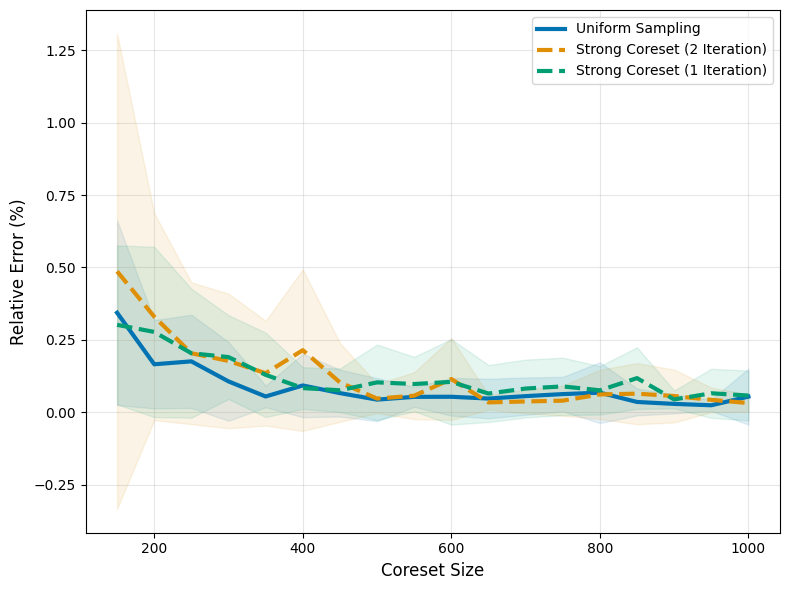

555.5611529350281


<Figure size 640x480 with 0 Axes>

In [17]:
start_time = time.time()
results_yt = compare_coreset_methods(df_data, coreset_sizes=None, n_repeats=20)
plot_coreset_comparison(results_yt)
print(time.time()-start_time)

In [30]:
# # Option 1: Using pickle (binary format)
# import pickle
# with open('results_taxi_dict.pkl', 'wb') as f:
#     pickle.dump(results, f)

# # Option 2: Using json (human-readable format)
# import json
# with open('results_taxi_dict.json', 'w') as f:
#     json.dump(results, f, indent=4)


# # results

### genomic dataset

In [3]:
import scanpy as sc

# Read the h5 file
adata = sc.read_10x_h5('l1_data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.h5')

/Users/amc9812/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/amc9812/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
import pandas as pd

genomic_df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)

# Optional: filter to only RNA features if there are multiple feature types
rna_features = adata.var[adata.var['feature_types'] == 'Gene Expression'].index
genomic_df = genomic_df[rna_features]

genomic_df.shape

(7865, 33586)

time 1550.3819930553436


Testing coreset sizes: 100%|█████████████████| 18/18 [1:34:58<00:00, 316.61s/it]



Summary Statistics:
Uniform Sampling:
  Mean Error: 0.0917% ± 0.0311%
  Average Construction Time: 0.017228 seconds
Strong Coreset (2 Iteration):
  Mean Error: 0.1054% ± 0.0353%
  Average Construction Time: 954.205592 seconds
Speed Improvement: 55386.7x
Strong Coreset (1 Iteration):
  Mean Error: 0.1018% ± 0.0314%
  Average Construction Time: 596.213986 seconds
Speed Improvement: 34607.1x


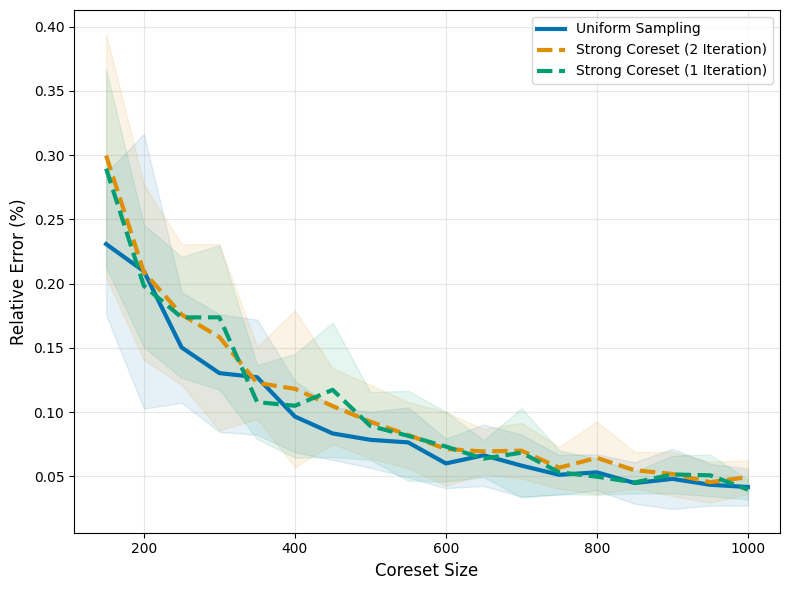

7249.594054937363


<Figure size 640x480 with 0 Axes>

In [19]:
start_time = time.time()
genom_results = compare_coreset_methods(genomic_df)
plot_coreset_comparison(genom_results,"scge")
print(time.time()-start_time)

### Twitter dataset

In [7]:
gps_df = pd.read_csv('l1_data/timestamped_gps_coordinate.txt',
                     sep='\t',
                     header=None,
                     names=['timestamp', 'coordinates'])

# Split the coordinates column
gps_df[['longitude', 'latitude']] = gps_df['coordinates'].str.split(expand=True).astype(float)

# Drop the original coordinate column
gps_df = gps_df.drop(columns=['coordinates'])

In [8]:
print(gps_df.head(10))
print(gps_df.shape)

    timestamp   longitude   latitude
0  1504866207    0.375267  52.263897
1  1504866208  121.035240  14.651666
2  1504866208  -61.205151 -27.213259
3  1504866209  101.690620   3.052764
4  1504866209   12.326700  45.438600
5  1504866209  135.503600  34.680219
6  1504866209  139.752568  35.654441
7  1504866209  139.776243  35.713305
8  1504866209    4.083330  48.300000
9  1504866210  103.854934   1.300463
(13603716, 3)


time 228.17608904838562


Testing coreset sizes: 100%|████████████████████| 18/18 [10:38<00:00, 35.50s/it]



Summary Statistics:
Uniform Sampling:
  Mean Error: 0.2205% ± 0.2911%
  Average Construction Time: 0.000101 seconds
Strong Coreset (2 Iteration):
  Mean Error: 0.3120% ± 0.4233%
  Average Construction Time: 113.708310 seconds
Speed Improvement: 1130323.0x
Strong Coreset (1 Iteration):
  Mean Error: 0.2608% ± 0.2966%
  Average Construction Time: 114.583390 seconds
Speed Improvement: 1139021.7x


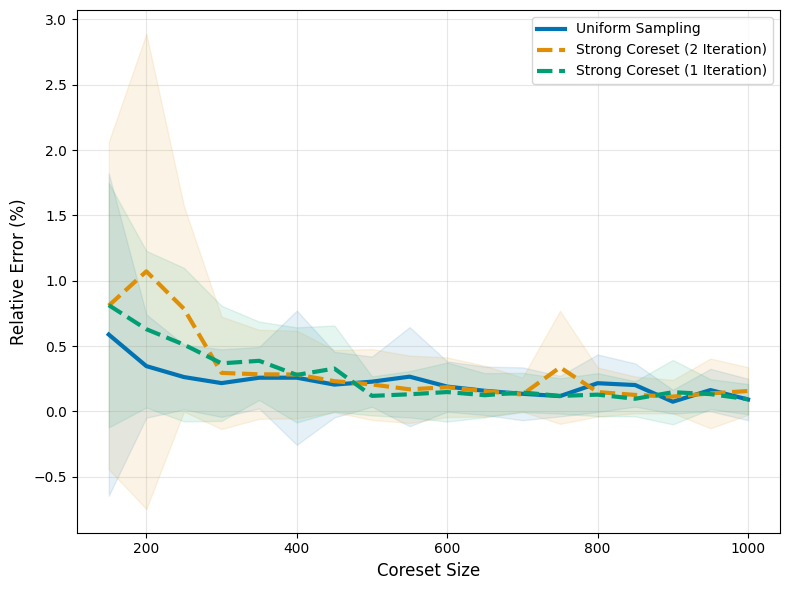

867.345535993576


<Figure size 640x480 with 0 Axes>

In [9]:
start_time = time.time()
results_gps = compare_coreset_methods(gps_df, coreset_sizes=None, n_repeats=20)
plot_coreset_comparison(results_gps,"twitter")
print(time.time()-start_time)


Summary Statistics:
Uniform Sampling:
  Mean Error: 0.2205% ± 0.2911%
  Average Construction Time: 0.000101 seconds
Strong Coreset (2 Iteration):
  Mean Error: 0.3120% ± 0.4233%
  Average Construction Time: 113.708310 seconds
Speed Improvement: 1130323.0x
Strong Coreset (1 Iteration):
  Mean Error: 0.2608% ± 0.2966%
  Average Construction Time: 114.583390 seconds
Speed Improvement: 1139021.7x


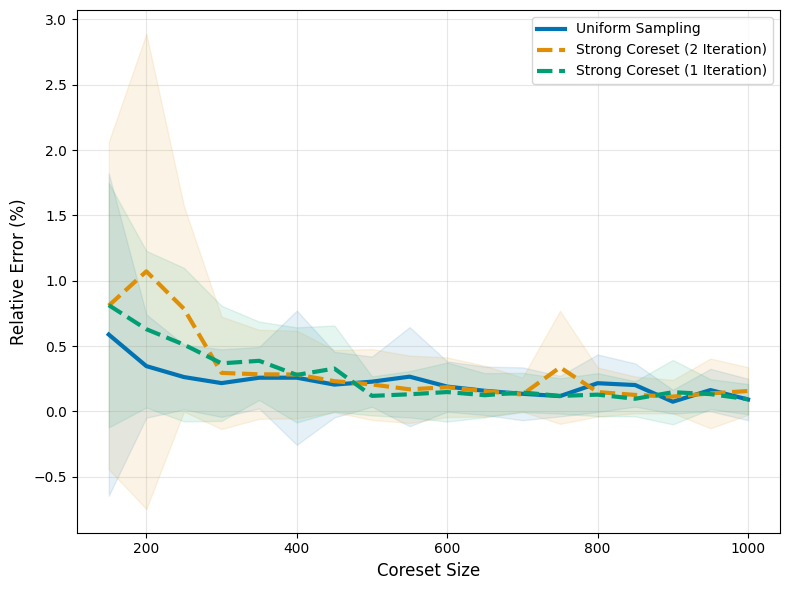

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
plot_coreset_comparison(results_gps,"twitter")